In [23]:
! uv pip install numpy pandas wfdb matplotlib ecgmentations pytorch_metric_learning --quiet

In [24]:
import torch
torch.cuda.is_available(), torch.cuda.is_bf16_supported()

(True, True)

In [25]:
import ast

import numpy as np
import pandas as pd
import wfdb


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_lr[:]]
    else:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_hr[:]]
    data = np.array([signal for signal, meta in data])
    return data


path = "/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
sampling_rate = 500

# load and convert annotation data
Y = pd.read_csv(path + "/ptbxl_database.csv", index_col="ecg_id")[:]
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + "/scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y["diagnostic_superclass"] = Y.scp_codes.apply(aggregate_diagnostic)




# Split data into train, validation, and test
test_fold = 10
val_fold = 9
# Train
X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold))]
y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].diagnostic_superclass
# Validation
X_val = X[np.where(Y.strat_fold == val_fold)]
y_val = Y[Y.strat_fold == val_fold].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [26]:
X_val.shape, X_test.shape, X_train.shape

((2193, 5000, 12), (2203, 5000, 12), (17441, 5000, 12))

In [27]:
# Check the data structure - see examples of diagnostic_superclass
print("Sample y_train values:")
print(y_train.head(10))
print("\nValue counts:")
print(y_train.apply(lambda x: len(x) if isinstance(x, list) else 0).value_counts())
print("\nSample with multiple labels:")
multi_label_examples = y_train[y_train.apply(lambda x: isinstance(x, list) and len(x) > 1)]
print(f"Found {len(multi_label_examples)} samples with multiple labels")
if len(multi_label_examples) > 0:
    print(multi_label_examples.head())

Sample y_train values:
ecg_id
1     [NORM]
2     [NORM]
3     [NORM]
4     [NORM]
5     [NORM]
6     [NORM]
7     [NORM]
11    [NORM]
12    [NORM]
13    [NORM]
Name: diagnostic_superclass, dtype: object

Value counts:
diagnostic_superclass
1    12978
2     3279
3      730
0      330
4      124
Name: count, dtype: int64

Sample with multiple labels:
Found 4133 samples with multiple labels
ecg_id
45      [HYP, CD]
50       [MI, CD]
77       [MI, CD]
87     [STTC, CD]
102    [STTC, CD]
Name: diagnostic_superclass, dtype: object


In [28]:
# Get all unique diagnostic classes
all_labels = []
for labels_list in pd.concat([y_train, y_val, y_test]):
    if isinstance(labels_list, list):
        all_labels.extend(labels_list)

unique_diagnostic_classes = sorted(set(all_labels))
print(f"Unique diagnostic classes: {unique_diagnostic_classes}")
print(f"Total number of classes: {len(unique_diagnostic_classes)}")

Unique diagnostic classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']
Total number of classes: 5


In [29]:
# Filter out rows with multiple labels (keep only single-label samples)
def filter_single_label(y_series, X_array):
    """Filter to keep only samples with exactly one label"""
    single_label_mask = y_series.apply(lambda x: isinstance(x, list) and len(x) == 1)
    y_filtered = y_series[single_label_mask].copy()
    X_filtered = X_array[single_label_mask.values]
    return X_filtered, y_filtered

# Apply filtering to train, val, and test sets
X_train_filtered, y_train_filtered = filter_single_label(y_train, X_train)
X_val_filtered, y_val_filtered = filter_single_label(y_val, X_val)
X_test_filtered, y_test_filtered = filter_single_label(y_test, X_test)

print("Original sizes:")
print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")
print("\nFiltered sizes (single label only):")
print(f"Train: {len(y_train_filtered)}, Val: {len(y_val_filtered)}, Test: {len(y_test_filtered)}")
print(f"\nRemoved {len(y_train) - len(y_train_filtered)} multi-label samples from train")
print(f"Removed {len(y_val) - len(y_val_filtered)} multi-label samples from val")
print(f"Removed {len(y_test) - len(y_test_filtered)} multi-label samples from test")

Original sizes:
Train: 17441, Val: 2193, Test: 2203

Filtered sizes (single label only):
Train: 12978, Val: 1642, Test: 1652

Removed 4463 multi-label samples from train
Removed 551 multi-label samples from val
Removed 551 multi-label samples from test


In [30]:
# Create label mapping from diagnostic class strings to integers
label_to_idx = {label: idx for idx, label in enumerate(unique_diagnostic_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print("Label mapping:")
for label, idx in label_to_idx.items():
    print(f"  {label} -> {idx}")

# Convert labels from list of strings to integers
def map_labels_to_int(y_series, label_mapping):
    """Convert single-element label lists to integer labels"""
    return y_series.apply(lambda x: label_mapping[x[0]])

y_train_int = map_labels_to_int(y_train_filtered, label_to_idx)
y_val_int = map_labels_to_int(y_val_filtered, label_to_idx)
y_test_int = map_labels_to_int(y_test_filtered, label_to_idx)

print("\nLabel distribution in train set:")
print(y_train_int.value_counts().sort_index())
print("\nLabel distribution in val set:")
print(y_val_int.value_counts().sort_index())
print("\nLabel distribution in test set:")
print(y_test_int.value_counts().sort_index())

Label mapping:
  CD -> 0
  HYP -> 1
  MI -> 2
  NORM -> 3
  STTC -> 4

Label distribution in train set:
diagnostic_superclass
0    1353
1     416
2    2048
3    7254
4    1907
Name: count, dtype: int64

Label distribution in val set:
diagnostic_superclass
0    172
1     64
2    234
3    916
4    256
Name: count, dtype: int64

Label distribution in test set:
diagnostic_superclass
0    184
1     56
2    256
3    913
4    243
Name: count, dtype: int64


In [31]:
# Summary of processed data
print("="*60)
print("SUMMARY: Data Processing Complete")
print("="*60)
print("\nLabel Mapping Dictionary:")
print(f"  label_to_idx = {label_to_idx}")
print(f"  idx_to_label = {idx_to_label}")
print("\nFinal Dataset Shapes:")
print(f"  X_train_filtered: {X_train_filtered.shape}, y_train_int: {y_train_int.shape}")
print(f"  X_val_filtered: {X_val_filtered.shape}, y_val_int: {y_val_int.shape}")
print(f"  X_test_filtered: {X_test_filtered.shape}, y_test_int: {y_test_int.shape}")
print("\nNote: Multi-label samples have been removed.")
print("      Labels are now integers in range [0, 4]")

SUMMARY: Data Processing Complete

Label Mapping Dictionary:
  label_to_idx = {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4}
  idx_to_label = {0: 'CD', 1: 'HYP', 2: 'MI', 3: 'NORM', 4: 'STTC'}

Final Dataset Shapes:
  X_train_filtered: (12978, 5000, 12), y_train_int: (12978,)
  X_val_filtered: (1642, 5000, 12), y_val_int: (1642,)
  X_test_filtered: (1652, 5000, 12), y_test_int: (1652,)

Note: Multi-label samples have been removed.
      Labels are now integers in range [0, 4]


# Data Augmenter and Dataset Classes

## Dual Augmenter Class

Custom augmentation class that ensures two augmented views are not identical.

In [32]:
import numpy as np
import random
import warnings
from scipy.spatial.distance import cosine
from typing import List, Callable, Tuple


class DualAugmenter:
    """
    Custom augmenter that produces two guaranteed-different augmented views.
    
    Ensures augmentation diversity through similarity checks with a retry mechanism.
    Enforces both minimum and maximum similarity to ensure positive pairs are
    similar enough to be meaningful but different enough to learn from.
    
    Args:
        augmentation_pool: List of augmentation functions to sample from
        min_similarity: Minimum cosine similarity allowed (default 0.5)
        max_similarity: Maximum cosine similarity allowed (default 0.995)
        max_retries: Maximum attempts to generate diverse pair (default 10)
    """
    
    def __init__(
        self,
        augmentation_pool: List[Callable],
        min_similarity: float = 0.5,
        max_similarity: float = 0.95,
        max_retries: int = 10,
    ):
        self.augmentation_pool = augmentation_pool
        self.min_similarity = min_similarity
        self.max_similarity = max_similarity
        self.max_retries = max_retries
        
        if min_similarity >= max_similarity:
            raise ValueError(f"min_similarity ({min_similarity}) must be less than max_similarity ({max_similarity})")
    
    def _calculate_similarity(self, aug1: np.ndarray, aug2: np.ndarray) -> float:
        """Calculate cosine similarity between two augmented signals."""
        return 1 - cosine(aug1.flatten(), aug2.flatten())
    
    def _are_identical(self, aug1: np.ndarray, aug2: np.ndarray) -> bool:
        """Quick check if augmentations are bit-for-bit identical."""
        return np.array_equal(aug1, aug2)
    
    def _sample_augmentation(self) -> Callable:
        """Randomly sample an augmentation from the pool."""
        return random.sample(self.augmentation_pool, k=1)[0]
    
    def __call__(self, ecg: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generate two diverse augmented views of the input signal.
        
        Args:
            ecg: Input ECG signal of shape (time_steps, num_channels)
            
        Returns:
            Tuple of (aug1, aug2) - two augmented views with similarity in valid range
        """
        best_aug1, best_aug2 = None, None
        best_similarity = 1.0
        best_distance_from_range = float('inf')
        
        for attempt in range(self.max_retries):
            # Sample two augmentations
            augmenter1 = self._sample_augmentation()
            augmenter2 = self._sample_augmentation()
            
            # Apply augmentations
            aug1 = augmenter1(ecg=ecg)["ecg"]
            aug2 = augmenter2(ecg=ecg)["ecg"]
            
            # Quick check: are they identical?
            if self._are_identical(aug1, aug2):
                continue
            
            # Check similarity
            similarity = self._calculate_similarity(aug1, aug2)
            
            # Calculate distance from valid range
            if similarity < self.min_similarity:
                distance_from_range = self.min_similarity - similarity
            elif similarity > self.max_similarity:
                distance_from_range = similarity - self.max_similarity
            else:
                distance_from_range = 0.0
            
            # Track best attempt (closest to valid range)
            if distance_from_range < best_distance_from_range:
                best_distance_from_range = distance_from_range
                best_similarity = similarity
                best_aug1, best_aug2 = aug1, aug2
            
            # Success: found pair within valid similarity range
            if self.min_similarity <= similarity <= self.max_similarity:
                return aug1, aug2
        
        # Max retries reached - return best attempt with warning
        if best_distance_from_range > 0:
            if best_similarity < self.min_similarity:
                # warnings.warn(
                #     f"Max retries ({self.max_retries}) reached. "
                #     f"Best similarity: {best_similarity:.4f} < min threshold: {self.min_similarity}"
                # )
                ...
            else:
                ...
                # warnings.warn(
                #     f"Max retries ({self.max_retries}) reached. "
                #     f"Best similarity: {best_similarity:.4f} > max threshold: {self.max_similarity}"
                # )
        
        return best_aug1, best_aug2

## Dataset Class

In [33]:
from typing import Optional, Tuple

import numpy as np
import torch


class ECGContrastiveTrainDataset(torch.utils.data.Dataset):
    """
    Updated ECG dataset for contrastive learning using DualAugmenter.
    
    This ensures that the two augmented views are guaranteed to be different,
    which is crucial for effective contrastive learning.
    
    Args:
        X: Input signals of shape (num_samples, time_steps, num_channels)
        y: Labels (used for filtering valid samples)
        dual_augmenter: DualAugmenter instance
    """

    def __init__(self, X: np.ndarray, y, dual_augmenter: DualAugmenter) -> None:
        # Filter out samples with multiple labels
        self.X = X
        self.y = y
        self.dual_augmenter = dual_augmenter

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        signal = self.X[idx, :, :]  # (time_steps, num_channels)
        
        # Use dual augmenter to get two diverse augmented views
        aug1, aug2 = self.dual_augmenter(ecg=signal)

        aug1_tensor = torch.tensor(aug1, dtype=torch.float32)
        aug2_tensor = torch.tensor(aug2, dtype=torch.float32)

        return aug1_tensor, aug2_tensor


class ECGDataset(torch.utils.data.Dataset):
    """
    ECG dataset for downstream tasks (classification, clustering, etc).

    Returns single signals with their labels for supervised or semi-supervised tasks.
    
    Assumes labels are already mapped to integers.

    Args:
        X: Input signals of shape (num_samples, time_steps, num_channels)
        y: Integer labels for each signal (array-like of integers)
    """

    def __init__(self, X: np.ndarray, y) -> None:
        self.X = X
        self.y = y.values if hasattr(y, "values") else np.array(y)
        
        # Ensure labels are integers
        if not np.issubdtype(self.y.dtype, np.integer):
            raise TypeError(f"Labels must be integers, got {self.y.dtype}")
        
        # Calculate number of classes
        self.num_classes = int(np.max(self.y)) + 1

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        signal = self.X[idx, :, :]  # (time_steps, num_channels)
        label = int(self.y[idx])

        signal_tensor = torch.tensor(signal, dtype=torch.float32)
        return signal_tensor, label


In [34]:
# Create datasets with integer labels
train_dataset_classification = ECGDataset(X=X_train_filtered, y=y_train_int)
val_dataset_classification = ECGDataset(X=X_val_filtered, y=y_val_int)
test_dataset_classification = ECGDataset(X=X_test_filtered, y=y_test_int)

print(f"Train dataset size: {len(train_dataset_classification)}")
print(f"Validation dataset size: {len(val_dataset_classification)}")
print(f"Test dataset size: {len(test_dataset_classification)}")
print(f"Number of classes: {test_dataset_classification.num_classes}")

# Test a sample
sample_signal, sample_label = val_dataset_classification[-1]
print(f"\nSample signal shape: {sample_signal.shape}")
print(f"Sample label (numerical): {sample_label}")

Train dataset size: 12978
Validation dataset size: 1642
Test dataset size: 1652
Number of classes: 5

Sample signal shape: torch.Size([5000, 12])
Sample label (numerical): 3


In [35]:
# Create DataLoaders for classification training
from torch.utils.data import DataLoader

# Create data loaders (datasets already created above with unified mapping)
batch_size = 32
train_loader_classification = DataLoader(
    train_dataset_classification, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2
)

val_loader_classification = DataLoader(
    val_dataset_classification, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2
)

test_loader_classification = DataLoader(
    test_dataset_classification, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=2
)

print(f"Created DataLoaders for classification:")
print(f"  Train: {len(train_dataset_classification)} samples, {len(train_loader_classification)} batches")
print(f"  Val:   {len(val_dataset_classification)} samples, {len(val_loader_classification)} batches")
print(f"  Test:  {len(test_dataset_classification)} samples, {len(test_loader_classification)} batches")

# Verify the data format
for signals, labels in train_loader_classification:
    print(f"\nBatch shapes:")
    print(f"  Signals: {signals.shape}")  # Should be (batch_size, time_steps, num_channels)
    print(f"  Labels: {labels.shape}, dtype: {labels.dtype}")  # Should be (batch_size,) with int dtype
    print(f"  Label range: [{labels.min()}, {labels.max()}]")
    break

Created DataLoaders for classification:
  Train: 12978 samples, 406 batches
  Val:   1642 samples, 52 batches
  Test:  1652 samples, 52 batches

Batch shapes:
  Signals: torch.Size([32, 5000, 12])
  Labels: torch.Size([32]), dtype: torch.int64
  Label range: [0, 4]

Batch shapes:
  Signals: torch.Size([32, 5000, 12])
  Labels: torch.Size([32]), dtype: torch.int64
  Label range: [0, 4]


In [36]:
import ecgmentations as E

# Example usage: Define augmentation pool
augmentation_pool = [
    E.TimeShift(p=1.0),
    E.GaussNoise(p=1.0),
    E.PowerlineNoise(p=1.0, ecg_frequency=60),
    E.RespirationNoise(p=1.0),
    E.AmplitudeScale(p=1.0),
    E.TimeCutout(p=1.0),
]

# Create dual augmenter with both min and max similarity thresholds
dual_augmenter = DualAugmenter(
    augmentation_pool=augmentation_pool,
    min_similarity=0.65,   # Augmentations must be at least 65% similar
    max_similarity=0.95,  # But not more than 95% similar
    max_retries=5,       # Increased retries due to tighter constraints
)


train_dataset = ECGContrastiveTrainDataset(X=X_train_filtered, y=y_train_int, dual_augmenter=dual_augmenter)
val_dataset = ECGContrastiveTrainDataset(X=X_val_filtered, y=y_val_int, dual_augmenter=dual_augmenter)
test_dataset = ECGContrastiveTrainDataset(X=X_test_filtered, y=y_test_int, dual_augmenter=dual_augmenter)


# Test it on a sample
sample_signal = X_train[0]
aug1, aug2 = dual_augmenter(sample_signal)

print(f"Original shape: {sample_signal.shape}")
print(f"Aug1 shape: {aug1.shape}")
print(f"Aug2 shape: {aug2.shape}")
print(f"Are they identical? {np.array_equal(aug1, aug2)}")

similarity = 1 - cosine(aug1.flatten(), aug2.flatten())
print(f"Cosine similarity: {similarity:.4f}")
print(f"Within range [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]? {dual_augmenter.min_similarity <= similarity <= dual_augmenter.max_similarity}")

Original shape: (5000, 12)
Aug1 shape: (5000, 12)
Aug2 shape: (5000, 12)
Are they identical? False
Cosine similarity: 0.9471
Within range [0.65, 0.95]? True


# SANITIZER PLACEHOLDER

# Training Pipeline

## Checkpointing Manager

In [38]:
import os
from dataclasses import asdict
from pathlib import Path


class CheckpointManager:
    """
    Manages model checkpointing during training.
    
    Features:
    - Saves model, optimizer, and training state after each epoch
    - Keeps track of best model based on lowest loss
    - Maintains only the last N checkpoints to save disk space
    - Supports resuming training from saved checkpoints
    """
    
    def __init__(
        self,
        checkpoint_dir: str = "../models/checkpoints",
        keep_last_n: int = 3,
        save_best: bool = True
    ):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.keep_last_n = keep_last_n
        self.save_best = save_best
        self.best_loss = float('inf')
        
    def save_checkpoint(
        self,
        model,
        optimizer,
        epoch: int,
        loss: float,
        config,
        additional_info: dict = None
    ):
        """Save checkpoint with model state, optimizer state, and metadata."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'config': asdict(config),
        }
        
        if additional_info:
            checkpoint.update(additional_info)
        
        # Save regular epoch checkpoint
        checkpoint_path = self.checkpoint_dir / f"checkpoint_epoch_{epoch}.pt"
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")
        
        # Save best model if this is the lowest loss
        if self.save_best and loss < self.best_loss:
            self.best_loss = loss
            best_path = self.checkpoint_dir / "best_model.pt"
            torch.save(checkpoint, best_path)
            print(f"New best model saved with loss: {loss:.4f}")
        
        # Save latest checkpoint (for easy resume)
        latest_path = self.checkpoint_dir / "latest.pt"
        torch.save(checkpoint, latest_path)
        
        # Clean up old checkpoints
        self._cleanup_old_checkpoints()
    
    def _cleanup_old_checkpoints(self):
        """Keep only the last N checkpoints to save disk space."""
        checkpoints = sorted(
            self.checkpoint_dir.glob("checkpoint_epoch_*.pt"),
            key=lambda p: int(p.stem.split('_')[-1])
        )
        
        # Remove old checkpoints beyond keep_last_n
        if len(checkpoints) > self.keep_last_n:
            for old_checkpoint in checkpoints[:-self.keep_last_n]:
                old_checkpoint.unlink()
                print(f"Removed old checkpoint: {old_checkpoint.name}")
    
    def load_checkpoint(self, checkpoint_path: str, model, optimizer=None, map_location=None):
        """
        Load checkpoint and restore model and optimizer states.
        
        Returns:
            Dictionary with epoch, loss, and config information
        """
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with loss {checkpoint['loss']:.4f}")
        return checkpoint
    
    def get_latest_checkpoint(self):
        """Get path to the latest checkpoint if it exists."""
        latest_path = self.checkpoint_dir / "latest.pt"
        return str(latest_path) if latest_path.exists() else None

## Defining Optimizer, Loss, and Training Loop

In [44]:
from pytorch_metric_learning.losses import NTXentLoss

In [46]:
import time
from typing import Optional

from tqdm import tqdm


def train(
    model,
    dataset,
    optimizer,
    loss_fn,
    config,
    batch_size=64,
    epochs=1,
    checkpoint_manager: CheckpointManager = None,
    resume_from: str = None,
    device: Optional[torch.device] = None,
    val_dataset = None
):
    """
    Train the ECG encoder with contrastive learning.
    
    Args:
        model: ECGEncoder model
        dataset: ECGContrastiveTrainDataset
        optimizer: Optimizer (e.g., Adam)
        loss_fn: Loss function (e.g., NTXentLoss)
        config: Model configuration
        batch_size: Batch size for training
        epochs: Number of epochs to train
        checkpoint_manager: CheckpointManager instance for saving checkpoints
        resume_from: Path to checkpoint to resume training from
        device: Torch device to run training on (auto-selected if None)
        val_dataset: Optional validation dataset for evaluation after each epoch
    """
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    
    model.to(device)
    start_epoch = 0
    loss_history = []
    val_loss_history = []
    
    # Resume from checkpoint if specified
    if resume_from:
        if checkpoint_manager is None:
            raise ValueError("resume_from requires a checkpoint_manager instance")
        checkpoint = checkpoint_manager.load_checkpoint(
            resume_from, model, optimizer, map_location=device
        )
        start_epoch = checkpoint['epoch']
        loss_history = checkpoint.get('loss_history', [])
        val_loss_history = checkpoint.get('val_loss_history', [])
        print(f"Resuming training from epoch {start_epoch + 1}")
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) if val_dataset else None
    
    training_start_time = time.time()

    for epoch in range(start_epoch, start_epoch + epochs):
        # Training phase
        model.train()
        epoch_start_time = time.time()
        total_loss = 0.0
        total_grad_norm = 0.0
        
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{start_epoch + epochs} [Train]")
        
        for batch_idx, (aug1, aug2) in enumerate(progress_bar):
            optimizer.zero_grad(set_to_none=True)
            aug1 = aug1.to(device, non_blocking=True)
            aug2 = aug2.to(device, non_blocking=True)

            _, proj1 = model(aug1)
            _, proj2 = model(aug2)

            embeddings = torch.cat((proj1, proj2), dim=0)
            indices = torch.arange(0, proj1.size(0), device=device)
            labels = torch.cat((indices, indices), dim=0)

            loss = loss_fn(embeddings, labels)
            loss.backward()
            
            # Calculate gradient norm
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=float('inf'))
            total_grad_norm += grad_norm.item()
            
            optimizer.step()
            total_loss += loss.item()
            
            # Update progress bar with real-time metrics
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'grad_norm': f'{grad_norm.item():.2f}'
            })

        # Calculate training epoch metrics
        avg_loss = total_loss / len(dataloader)
        avg_grad_norm = total_grad_norm / len(dataloader) if len(dataloader) else 0.0
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - training_start_time
        
        loss_history.append(avg_loss)
        
        # Validation phase
        val_loss = None
        if val_dataloader:
            model.eval()
            val_total_loss = 0.0
            val_progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch + 1}/{start_epoch + epochs} [Val]")
            
            with torch.no_grad():
                for aug1, aug2 in val_progress_bar:
                    aug1 = aug1.to(device, non_blocking=True)
                    aug2 = aug2.to(device, non_blocking=True)

                    _, proj1 = model(aug1)
                    _, proj2 = model(aug2)

                    embeddings = torch.cat((proj1, proj2), dim=0)
                    indices = torch.arange(0, proj1.size(0), device=device)
                    labels = torch.cat((indices, indices), dim=0)

                    loss = loss_fn(embeddings, labels)
                    val_total_loss += loss.item()
                    
                    val_progress_bar.set_postfix({'val_loss': f'{loss.item():.4f}'})
            
            val_loss = val_total_loss / len(val_dataloader)
            val_loss_history.append(val_loss)
        
        # Print epoch summary
        summary = (f"Epoch [{epoch + 1}/{start_epoch + epochs}] "
                  f"Train Loss: {avg_loss:.4f} | "
                  f"Grad Norm: {avg_grad_norm:.2f} | ")
        if val_loss is not None:
            summary += f"Val Loss: {val_loss:.4f} | "
        summary += f"Time: {epoch_time:.1f}s | Total: {total_time:.1f}s"
        print(summary)
        
        # Save checkpoint after each epoch
        if checkpoint_manager:
            additional_info = {
                'loss_history': loss_history,
                'avg_grad_norm': avg_grad_norm,
                'epoch_time': epoch_time,
                'total_training_time': total_time
            }
            if val_loss is not None:
                additional_info['val_loss_history'] = val_loss_history
                additional_info['val_loss'] = val_loss
            
            checkpoint_manager.save_checkpoint(
                model=model,
                optimizer=optimizer,
                epoch=epoch + 1,
                loss=avg_loss,
                config=config,
                additional_info=additional_info
            )
    
    total_time = time.time() - training_start_time
    print(f"\nTraining completed in {total_time:.1f}s ({total_time/60:.1f} minutes)")
    
    result = {'loss_history': loss_history}
    if val_loss_history:
        result['val_loss_history'] = val_loss_history
    return result

# Evaluation Pipeline
We will plot the test-set in 2-d using PCA and add the labels as the colors.

In [41]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np


def extract_embeddings(model, dataloader, device=None):
    """
    Extract embeddings and labels from the model for a given dataset.
    
    Args:
        model: Trained ECGEncoder
        dataloader: DataLoader with (signal, label) pairs
        device: Device to run inference on
        
    Returns:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for signals, labels in dataloader:
            signals = signals.to(device)
            representations, _ = model(signals)  # Use representations, not projections
            all_embeddings.append(representations.to(torch.float32).cpu().numpy())
            # Labels are already integers from ECGDataset
            all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    
    embeddings = np.concatenate(all_embeddings, axis=0)
    labels_array = np.array(all_labels, dtype=int)
    return embeddings, labels_array


def plot_embeddings_2d(embeddings, labels, method='pca', title='ECG Embeddings Visualization', 
                        figsize=(12, 8), label_names=None):
    """
    Plot embeddings in 2D using PCA or t-SNE.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels for each sample
        method: 'pca' or 'tsne'
        title: Plot title
        figsize: Figure size
        label_names: Optional dict mapping integer labels to class names (e.g., {0: 'Normal', 1: 'AF', ...})
    """
    # Ensure labels are numpy array
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels, dtype=int)
    
    # Reduce to 2D
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings)
        explained_var = reducer.explained_variance_ratio_
        subtitle = f'Explained variance: {explained_var[0]:.2%} (PC1), {explained_var[1]:.2%} (PC2)'
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embeddings_2d = reducer.fit_transform(embeddings)
        subtitle = 't-SNE projection'
    else:
        raise ValueError("method must be 'pca' or 'tsne'")
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=labels, 
        cmap='tab10', 
        alpha=0.6,
        s=20
    )
    
    # Add legend with optional label names
    if label_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=scatter.cmap(scatter.norm(label)), 
                              markersize=8, label=label_names.get(label, f'Class {label}')) 
                   for label in unique_labels]
    else:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=scatter.cmap(scatter.norm(label)), 
                              markersize=8, label=f'Class {label}') 
                   for label in unique_labels]
    
    ax.legend(handles=handles, title='Diagnostic Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f'{title}\n{subtitle}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, unique_labels


def calculate_clustering_metrics(embeddings, labels):
    """
    Calculate clustering quality metrics.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels
        
    Returns:
        Dictionary with clustering metrics
    """
    # Ensure labels are numpy array of integers
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels, dtype=int)
    
    # Get unique labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Calculate metrics
    metrics = {
        'silhouette_score': silhouette_score(embeddings, labels),
        'davies_bouldin_score': davies_bouldin_score(embeddings, labels),
        'calinski_harabasz_score': calinski_harabasz_score(embeddings, labels),
        'n_samples': len(labels),
        'n_classes': len(unique_labels),
        'class_distribution': {int(label): int(count) for label, count in zip(unique_labels, counts)}
    }
    
    return metrics


def print_clustering_metrics(metrics, label_names=None):
    """
    Pretty print clustering metrics.
    
    Args:
        metrics: Dictionary of clustering metrics from calculate_clustering_metrics
        label_names: Optional dict mapping integer labels to class names (e.g., {0: 'Normal', 1: 'AF', ...})
    """
    print("=" * 60)
    print("CLUSTERING QUALITY METRICS")
    print("=" * 60)
    print(f"Number of samples: {metrics['n_samples']}")
    print(f"Number of classes: {metrics['n_classes']}")
    print()
    print("Metrics:")
    print(f"  Silhouette Score:        {metrics['silhouette_score']:.4f}")
    print(f"    (Range: [-1, 1], Higher is better)")
    print(f"    > 0.5: Strong separation")
    print(f"    > 0.3: Reasonable separation")
    print()
    print(f"  Davies-Bouldin Score:    {metrics['davies_bouldin_score']:.4f}")
    print(f"    (Range: [0, ∞], Lower is better)")
    print(f"    < 1.0: Good clustering")
    print()
    print(f"  Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}")
    print(f"    (Range: [0, ∞], Higher is better)")
    print()
    print("Class Distribution:")
    for label, count in sorted(metrics['class_distribution'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / metrics['n_samples']) * 100
        if label_names is not None:
            label_str = label_names.get(label, f'Class {label}')
        else:
            label_str = f'Class {label}'
        print(f"  {label_str:20s}: {count:4d} samples ({percentage:5.1f}%)")
    print("=" * 60)


# Baseline Model: 1D ResNet for ECG

This is a simpler baseline model based on ResNet architecture, commonly used in time-series classification papers:
- **Paper**: "Deep Residual Learning for Image Recognition" (He et al., 2015)
- **Adapted for 1D signals**: Used in many ECG papers including "Cardiologist-level arrhythmia detection" (Rajpurkar et al., 2017)
- **Architecture**: ResNet-18 style with 1D convolutions
- **Benefits**: Proven architecture, easier to train, fewer parameters

## Model Architecture

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass


@dataclass
class SimpleECGConfig:
    """Configuration for simple ResNet-based ECG encoder."""
    sequence_length: int = 5000
    num_channels: int = 12
    base_filters: int = 128
    projection_dim: int = 256
    dropout: float = 0.1
    dtype: torch.dtype = torch.float32


class BasicBlock1D(nn.Module):
    """Basic residual block for 1D convolutions."""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=7, 
                               stride=stride, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=7,
                               stride=1, padding=3, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class SimpleECGEncoder(nn.Module):
    """
    Simple ResNet-based encoder for ECG signals.
    
    Architecture inspired by:
    - He et al., "Deep Residual Learning for Image Recognition" (2015)
    - Rajpurkar et al., "Cardiologist-level arrhythmia detection" (2017)
    
    This is a much simpler baseline compared to the complex transformer architecture.
    """
    
    def __init__(self, config: SimpleECGConfig):
        super().__init__()
        self.config = config
        
        # Initial convolution to project channels
        self.conv1 = nn.Conv1d(config.num_channels, config.base_filters, 
                               kernel_size=15, stride=2, padding=7, bias=False)
        self.bn1 = nn.BatchNorm1d(config.base_filters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(config.base_filters, config.base_filters, 2, stride=1)
        self.layer2 = self._make_layer(config.base_filters, config.base_filters * 2, 2, stride=2)
        self.layer3 = self._make_layer(config.base_filters * 2, config.base_filters * 4, 2, stride=2)
        self.layer4 = self._make_layer(config.base_filters * 4, config.base_filters * 8, 2, stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        
        # Projection head for contrastive learning
        self.projection_head = nn.Sequential(
            nn.Linear(config.base_filters * 8, config.base_filters * 4),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.base_filters * 4, config.projection_dim)
        )
        
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels),
            )
        
        layers = []
        layers.append(BasicBlock1D(in_channels, out_channels, stride, downsample, self.config.dropout))
        for _ in range(1, blocks):
            layers.append(BasicBlock1D(out_channels, out_channels, dropout=self.config.dropout))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # x shape: (batch, time, channels) -> need (batch, channels, time)
        if x.dim() == 3:
            x = x.permute(0, 2, 1)
        
        # Initial conv
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global pooling
        x = self.avgpool(x)
        representation = x.squeeze(-1)  # (batch, base_filters * 8)
        
        # Projection for contrastive learning
        projection = self.projection_head(representation)
        projection = F.normalize(projection, dim=-1)
        
        return representation, projection


# Test the model
print("Creating simple baseline model...")
simple_config = SimpleECGConfig()
simple_model = SimpleECGEncoder(simple_config)

# Count parameters
total_params = sum(p.numel() for p in simple_model.parameters())
trainable_params = sum(p.numel() for p in simple_model.parameters() if p.requires_grad)

print(f"\nSimple Model Summary:")
print(f"\nCompare to complex model: {total_params / 1_000_000:.2f}M parameters")

Creating simple baseline model...

Simple Model Summary:

Compare to complex model: 35.56M parameters


In [48]:
# Initialize simple model with same training setup
simple_model = SimpleECGEncoder(SimpleECGConfig())
simple_optimizer = torch.optim.AdamW(simple_model.parameters(), lr=1e-4)  # Slightly higher LR for simpler model
simple_loss_fn = NTXentLoss(temperature=0.5)

# Train the baseline model
print("Training simple ResNet baseline model...")
print("=" * 80)

simple_history = train(
    model=simple_model,
    dataset=train_dataset,
    optimizer=simple_optimizer,
    loss_fn=simple_loss_fn,
    config=SimpleECGConfig(),
    batch_size=64,
    epochs=20,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints_simple",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)

Training simple ResNet baseline model...


Epoch 1/20 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.17it/s, val_loss=2.7816]



Epoch [1/20] Train Loss: 3.2388 | Grad Norm: 1.67 | Val Loss: 3.0819 | Time: 244.9s | Total: 244.9s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_1.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_1.pt
New best model saved with loss: 3.2388
New best model saved with loss: 3.2388
Removed old checkpoint: checkpoint_epoch_1.pt
Removed old checkpoint: checkpoint_epoch_1.pt


Epoch 2/20 [Val]: 100%|██████████| 26/26 [00:21<00:00,  1.21it/s, val_loss=2.7229]



Epoch [2/20] Train Loss: 3.0815 | Grad Norm: 1.20 | Val Loss: 3.0223 | Time: 235.1s | Total: 503.9s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_2.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_2.pt
New best model saved with loss: 3.0815
New best model saved with loss: 3.0815
Removed old checkpoint: checkpoint_epoch_2.pt
Removed old checkpoint: checkpoint_epoch_2.pt


Epoch 3/20 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.18it/s, val_loss=2.6472]



Epoch [3/20] Train Loss: 3.0515 | Grad Norm: 0.98 | Val Loss: 3.0013 | Time: 239.5s | Total: 766.7s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_3.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_3.pt
New best model saved with loss: 3.0515
New best model saved with loss: 3.0515
Removed old checkpoint: checkpoint_epoch_3.pt
Removed old checkpoint: checkpoint_epoch_3.pt


Epoch 4/20 [Val]: 100%|██████████| 26/26 [00:21<00:00,  1.18it/s, val_loss=2.6390]



Epoch [4/20] Train Loss: 3.0336 | Grad Norm: 0.87 | Val Loss: 2.9934 | Time: 240.4s | Total: 1030.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_4.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_4.pt
New best model saved with loss: 3.0336
New best model saved with loss: 3.0336
Removed old checkpoint: checkpoint_epoch_4.pt
Removed old checkpoint: checkpoint_epoch_4.pt


Epoch 5/20 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s, val_loss=2.6305]



Epoch [5/20] Train Loss: 3.0214 | Grad Norm: 0.78 | Val Loss: 2.9818 | Time: 239.9s | Total: 1294.4s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_5.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_5.pt
New best model saved with loss: 3.0214
New best model saved with loss: 3.0214
Removed old checkpoint: checkpoint_epoch_5.pt
Removed old checkpoint: checkpoint_epoch_5.pt


Epoch 6/20 [Val]: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s, val_loss=2.6508]



Epoch [6/20] Train Loss: 3.0093 | Grad Norm: 0.69 | Val Loss: 2.9941 | Time: 237.3s | Total: 1555.7s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_6.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_6.pt
New best model saved with loss: 3.0093
New best model saved with loss: 3.0093
Removed old checkpoint: checkpoint_epoch_6.pt
Removed old checkpoint: checkpoint_epoch_6.pt


Epoch 7/20 [Val]: 100%|██████████| 26/26 [00:21<00:00,  1.20it/s, val_loss=2.6422]



Epoch [7/20] Train Loss: 3.0009 | Grad Norm: 0.65 | Val Loss: 2.9783 | Time: 238.6s | Total: 1817.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_7.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_7.pt
New best model saved with loss: 3.0009
New best model saved with loss: 3.0009
Removed old checkpoint: checkpoint_epoch_7.pt
Removed old checkpoint: checkpoint_epoch_7.pt


Epoch 8/20 [Val]: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s, val_loss=2.6605]



Epoch [8/20] Train Loss: 2.9962 | Grad Norm: 0.62 | Val Loss: 2.9816 | Time: 240.6s | Total: 2081.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_8.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_8.pt
New best model saved with loss: 2.9962
New best model saved with loss: 2.9962
Removed old checkpoint: checkpoint_epoch_8.pt
Removed old checkpoint: checkpoint_epoch_8.pt


Epoch 9/20 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.17it/s, val_loss=2.6718]



Epoch [9/20] Train Loss: 2.9922 | Grad Norm: 0.60 | Val Loss: 3.0069 | Time: 239.2s | Total: 2344.6s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_9.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_9.pt
New best model saved with loss: 2.9922
New best model saved with loss: 2.9922
Removed old checkpoint: checkpoint_epoch_9.pt
Removed old checkpoint: checkpoint_epoch_9.pt


Epoch 10/20 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.18it/s, val_loss=2.6287]



Epoch [10/20] Train Loss: 2.9885 | Grad Norm: 0.56 | Val Loss: 2.9792 | Time: 238.5s | Total: 2606.9s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_10.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_10.pt
New best model saved with loss: 2.9885
New best model saved with loss: 2.9885
Removed old checkpoint: checkpoint_epoch_10.pt
Removed old checkpoint: checkpoint_epoch_10.pt


Epoch 11/20 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.18it/s, val_loss=2.6189]



Epoch [11/20] Train Loss: 2.9831 | Grad Norm: 0.54 | Val Loss: 2.9717 | Time: 238.5s | Total: 2869.2s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_11.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_11.pt
New best model saved with loss: 2.9831
New best model saved with loss: 2.9831
Removed old checkpoint: checkpoint_epoch_11.pt
Removed old checkpoint: checkpoint_epoch_11.pt


Epoch 12/20 [Val]: 100%|██████████| 26/26 [00:21<00:00,  1.19it/s, val_loss=2.6304]



Epoch [12/20] Train Loss: 2.9810 | Grad Norm: 0.52 | Val Loss: 2.9695 | Time: 238.2s | Total: 3131.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_12.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_12.pt
New best model saved with loss: 2.9810
New best model saved with loss: 2.9810
Removed old checkpoint: checkpoint_epoch_12.pt
Removed old checkpoint: checkpoint_epoch_12.pt


Epoch 13/20 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.17it/s, val_loss=2.5834]



Epoch [13/20] Train Loss: 2.9756 | Grad Norm: 0.50 | Val Loss: 2.9674 | Time: 235.9s | Total: 3390.6s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_13.pt
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_13.pt
New best model saved with loss: 2.9756
New best model saved with loss: 2.9756
Removed old checkpoint: checkpoint_epoch_13.pt
Removed old checkpoint: checkpoint_epoch_13.pt


Epoch 14/20 [Train]:  51%|█████     | 103/203 [02:03<01:59,  1.20s/it, loss=2.9703, grad_norm=0.50]



KeyboardInterrupt: 

NameError: name 'simple_history' is not defined

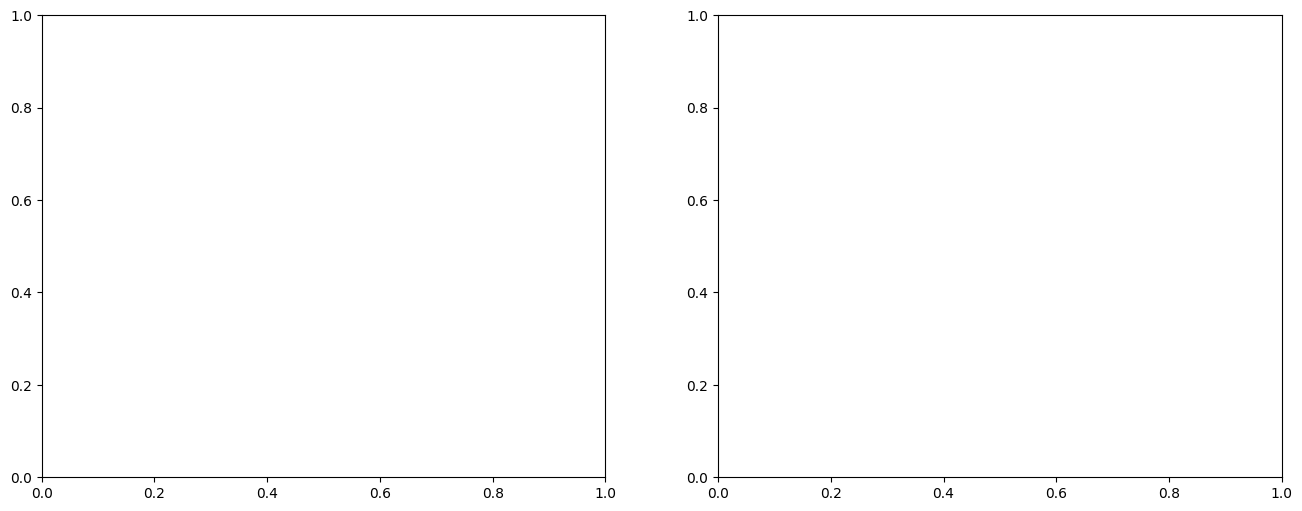

In [49]:
# Compare training curves: Complex vs Simple model
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training loss comparison
axes[0].plot(range(1, len(simple_history['loss_history']) + 1), 
             simple_history['loss_history'], 'b-', label='Complex Model', linewidth=2, marker='o')
axes[0].plot(range(1, len(simple_history['loss_history']) + 1), 
             simple_history['loss_history'], 'r-', label='Simple ResNet', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Validation loss comparison
if 'val_loss_history' in simple_history and 'val_loss_history' in simple_history:
    axes[1].plot(range(1, len(simple_history['val_loss_history']) + 1), 
                 simple_history['val_loss_history'], 'b--', label='Complex Model', linewidth=2, marker='o')
    axes[1].plot(range(1, len(simple_history['val_loss_history']) + 1), 
                 simple_history['val_loss_history'], 'r--', label='Simple ResNet', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Loss', fontsize=12)
    axes[1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print("\nComplex Transformer Model:")
print(f"  Final Training Loss:   {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history:
    print(f"  Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"  Best Validation Loss:  {min(simple_history['val_loss_history']):.4f}")

print("\nSimple ResNet Baseline:")
print(f"  Final Training Loss:   {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history:
    print(f"  Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"  Best Validation Loss:  {min(simple_history['val_loss_history']):.4f}")

print("\n" + "=" * 80)

## Evaluate Simple Model Embeddings

Let's evaluate the quality of embeddings from the simple ResNet model and compare clustering metrics.

In [50]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Extract embeddings from simple model
print("Extracting embeddings from simple ResNet model...")
simple_embeddings, simple_labels = extract_embeddings(simple_model, test_loader_classification)
print(f"Extracted {len(simple_embeddings)} embeddings with dimension {simple_embeddings.shape[1]}")

# Calculate clustering metrics for simple model
simple_metrics = calculate_clustering_metrics(simple_embeddings, simple_labels)
print("\n" + "=" * 80)
print("SIMPLE RESNET MODEL - CLUSTERING METRICS")
print_clustering_metrics(simple_metrics)

Extracting embeddings from simple ResNet model...


Extracted 1652 embeddings with dimension 1024

SIMPLE RESNET MODEL - CLUSTERING METRICS
CLUSTERING QUALITY METRICS
Number of samples: 1652
Number of classes: 5

Metrics:
  Silhouette Score:        0.0016
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable separation

  Davies-Bouldin Score:    5.7146
    (Range: [0, ∞], Lower is better)
    < 1.0: Good clustering

  Calinski-Harabasz Score: 24.45
    (Range: [0, ∞], Higher is better)

Class Distribution:
  Class 3             :  913 samples ( 55.3%)
  Class 2             :  256 samples ( 15.5%)
  Class 4             :  243 samples ( 14.7%)
  Class 0             :  184 samples ( 11.1%)
  Class 1             :   56 samples (  3.4%)



Generating PCA visualization for simple model...


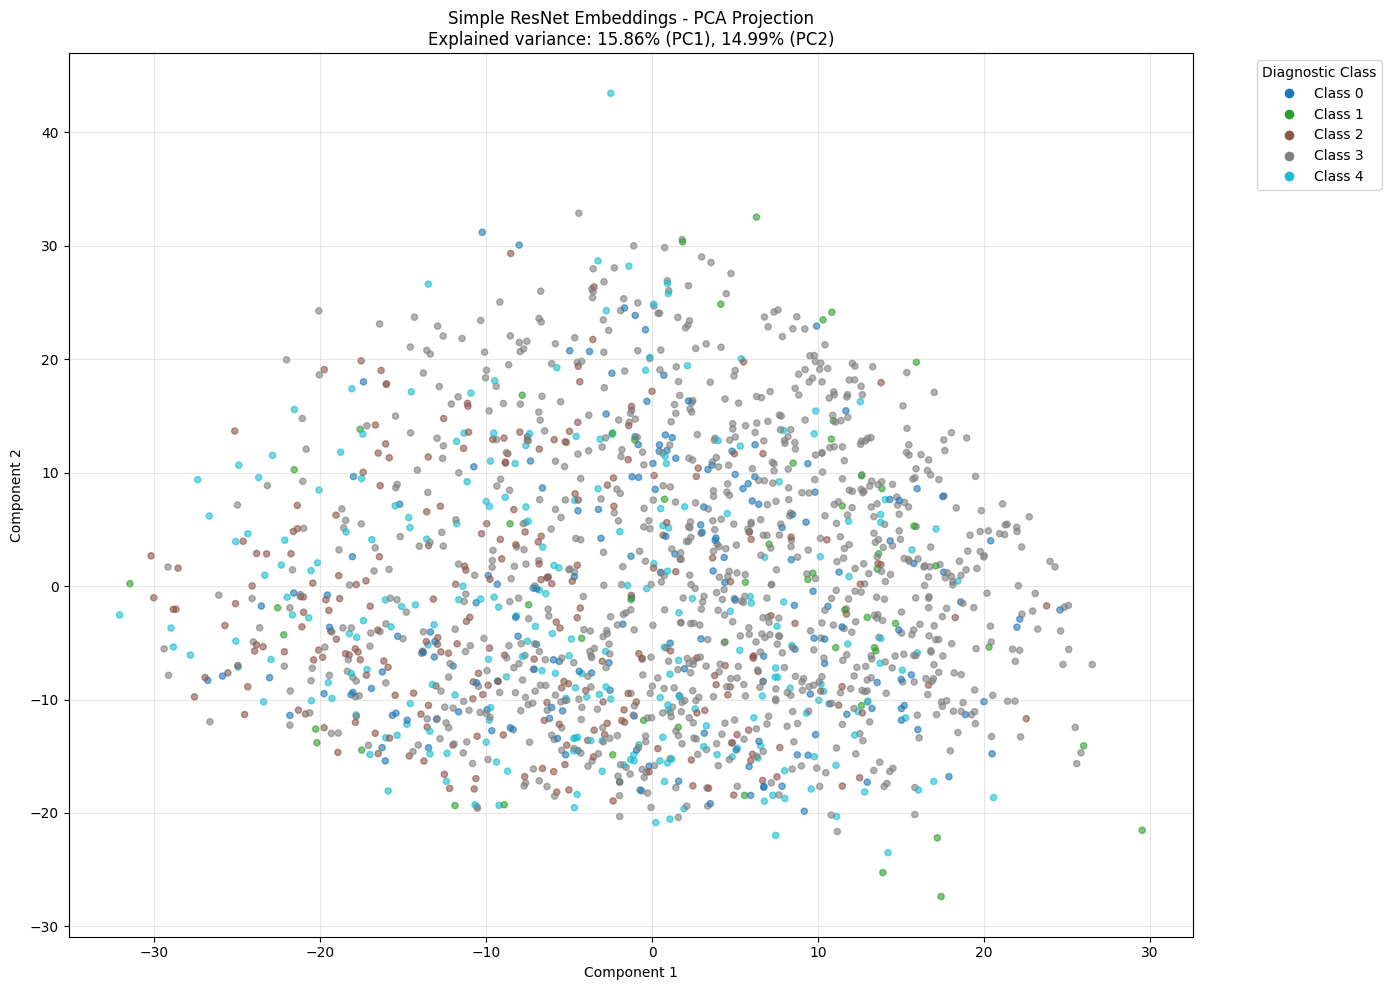

In [51]:
# Visualize simple model embeddings with PCA
print("\nGenerating PCA visualization for simple model...")
simple_embeddings_2d_pca, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='pca', 
    title='Simple ResNet Embeddings - PCA Projection',
    figsize=(14, 10)
)


Generating t-SNE visualization for simple model...


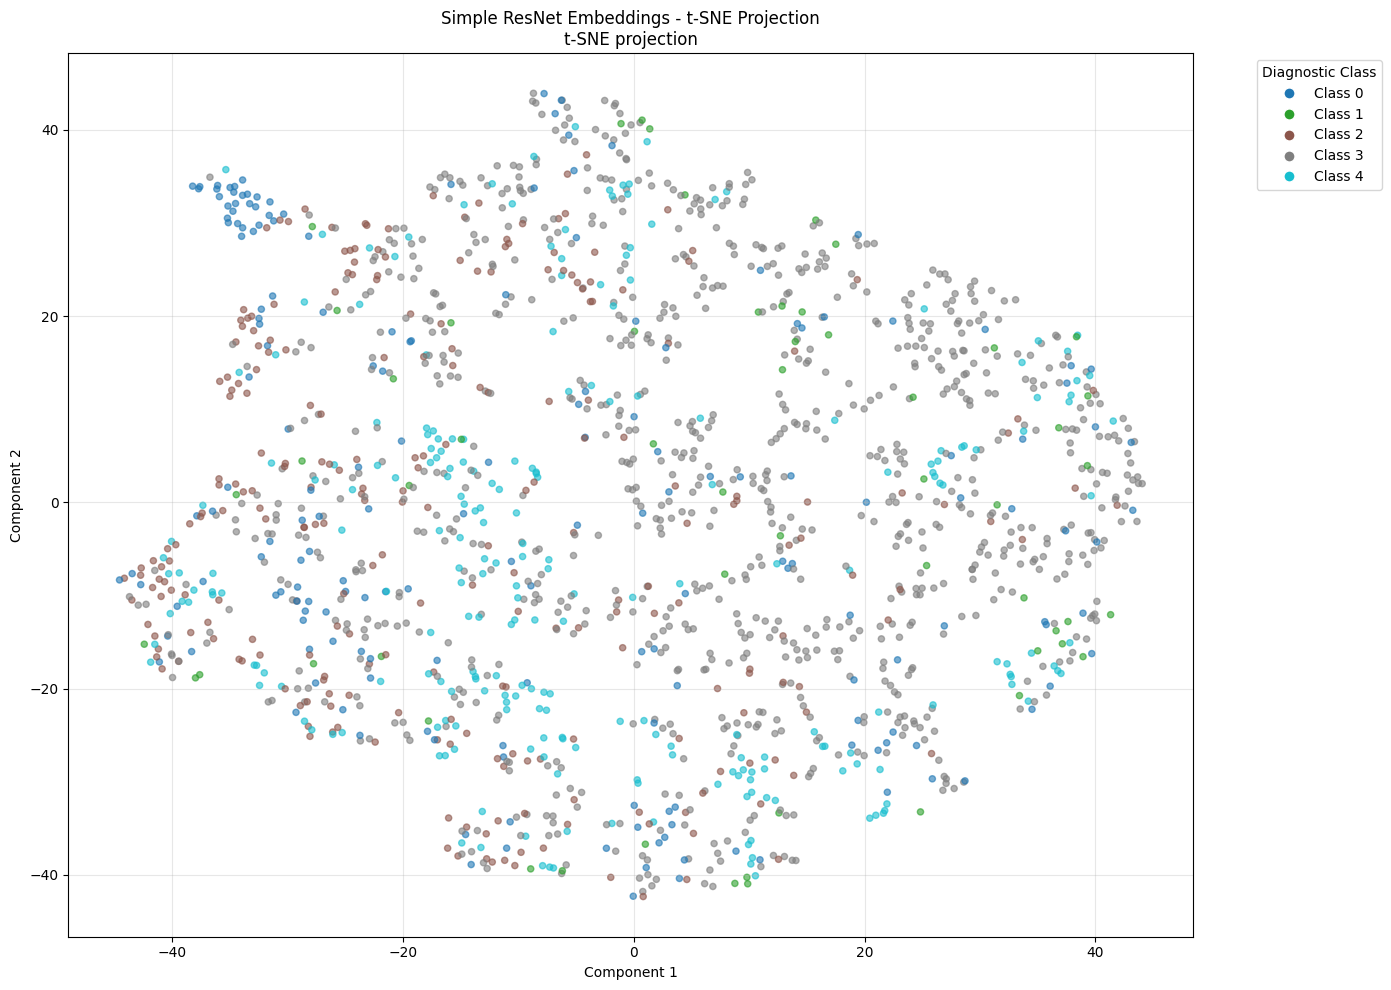

In [52]:
# Visualize simple model embeddings with t-SNE
print("\nGenerating t-SNE visualization for simple model...")
simple_embeddings_2d_tsne, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='tsne', 
    title='Simple ResNet Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

## Final Comparison & Analysis

Let's create a comprehensive comparison between the two models to identify what's working and what's not.

In [ ]:
# Comprehensive comparison table
import pandas as pd

comparison_data = {
    'Metric': [
        'Total Parameters',
        'Final Training Loss',
        'Final Validation Loss',
        'Best Validation Loss',
        'Silhouette Score',
        'Davies-Bouldin Score',
        'Calinski-Harabasz Score',
        'Embedding Dimension'
    ],
    'Complex Transformer': [
        f"{sum(p.numel() for p in model.parameters()):,}",
        f"{history['loss_history'][-1]:.4f}",
        f"{history.get('val_loss_history', [0])[-1]:.4f}" if 'val_loss_history' in history else "N/A",
        f"{min(history.get('val_loss_history', [0])):.4f}" if 'val_loss_history' in history else "N/A",
        f"{metrics['silhouette_score']:.4f}",
        f"{metrics['davies_bouldin_score']:.4f}",
        f"{metrics['calinski_harabasz_score']:.2f}",
        f"{embeddings.shape[1]}"
    ],
    'Simple ResNet': [
        f"{sum(p.numel() for p in simple_model.parameters()):,}",
        f"{simple_history['loss_history'][-1]:.4f}",
        f"{simple_history.get('val_loss_history', [0])[-1]:.4f}" if 'val_loss_history' in simple_history else "N/A",
        f"{min(simple_history.get('val_loss_history', [0])):.4f}" if 'val_loss_history' in simple_history else "N/A",
        f"{simple_metrics['silhouette_score']:.4f}",
        f"{simple_metrics['davies_bouldin_score']:.4f}",
        f"{simple_metrics['calinski_harabasz_score']:.2f}",
        f"{simple_embeddings.shape[1]}"
    ],
    'Better': [
        'Simple (fewer params)',
        'Lower is better',
        'Lower is better',
        'Lower is better',
        'Higher is better',
        'Lower is better',
        'Higher is better',
        'N/A'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Determine winner for each metric
print("\n📊 METRIC-BY-METRIC ANALYSIS:\n")

def compare_metric(name, complex_val, simple_val, higher_better=False):
    try:
        c = float(complex_val)
        s = float(simple_val)
        if higher_better:
            winner = "Simple ResNet" if s > c else "Complex Transformer"
            diff = ((s - c) / abs(c)) * 100
        else:
            winner = "Simple ResNet" if s < c else "Complex Transformer"
            diff = ((c - s) / abs(c)) * 100
        print(f"  {name:30s}: {winner:20s} (difference: {abs(diff):+.1f}%)")
    except:
        print(f"  {name:30s}: Unable to compare")

compare_metric("Training Loss", history['loss_history'][-1], simple_history['loss_history'][-1], False)
if 'val_loss_history' in history and 'val_loss_history' in simple_history:
    compare_metric("Validation Loss", history['val_loss_history'][-1], simple_history['val_loss_history'][-1], False)
compare_metric("Silhouette Score", metrics['silhouette_score'], simple_metrics['silhouette_score'], True)
compare_metric("Davies-Bouldin Score", metrics['davies_bouldin_score'], simple_metrics['davies_bouldin_score'], False)
compare_metric("Calinski-Harabasz Score", metrics['calinski_harabasz_score'], simple_metrics['calinski_harabasz_score'], True)

print("\n" + "=" * 100)


COMPREHENSIVE MODEL COMPARISON
                 Metric Complex Transformer Simple ResNet                Better
       Total Parameters             237,601    35,563,520 Simple (fewer params)
    Final Training Loss              4.6740        3.0205       Lower is better
  Final Validation Loss              4.5885        2.9245       Lower is better
   Best Validation Loss              4.5521        2.9245       Lower is better
       Silhouette Score             -0.0154       -0.0292      Higher is better
   Davies-Bouldin Score             13.6939        7.2548       Lower is better
Calinski-Harabasz Score                2.00         12.38      Higher is better
    Embedding Dimension                  44          1024                   N/A

📊 METRIC-BY-METRIC ANALYSIS:

  Training Loss                 : Simple ResNet        (difference: +35.4%)
  Validation Loss               : Simple ResNet        (difference: +36.3%)
  Silhouette Score              : Complex Transformer  (differenc

# Our Architecture

In [64]:
import math
from dataclasses import dataclass
from typing import Tuple

import torch
import torch.nn.functional as F
from torch import nn


@dataclass
class ECGModelConfig:
    sequence_length: int = 5000
    num_channels: int = 12
    d_model: int = 64
    time_heads: int = 4
    channel_heads: int = 4
    time_layers: int = 4
    channel_layers: int = 4
    ff_multiplier: int = 4
    dropout: float = 0.35
    temperature: float = 0.5
    projection_dim: int = 128
    dtype: torch.dtype = torch.bfloat16


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int, dtype: torch.dtype) -> None:
        super().__init__()
        position = torch.arange(0, max_len, dtype=dtype).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=dtype) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, d_model, dtype=dtype)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:, : x.size(1)]


class TimeTransformer(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.input_proj = nn.Linear(
            config.num_channels, config.d_model, dtype=config.dtype
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.d_model,
            nhead=config.time_heads,
            dim_feedforward=config.d_model * config.ff_multiplier,
            dropout=config.dropout,
            batch_first=True,
            activation="relu",
            dtype=config.dtype,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=config.time_layers
        )
        self.positional_encoding = SinusoidalPositionalEncoding(
            config.d_model, config.sequence_length, config.dtype
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dtype != self.input_proj.weight.dtype:
            x = x.to(self.input_proj.weight.dtype)
        x = self.input_proj(x)
        x = self.positional_encoding(x)
        return self.encoder(x)


class ChannelTransformer(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        # Pool across time dimension first, then project to d_model
        self.pool = nn.AdaptiveAvgPool1d(512)
        self.channel_proj = nn.Linear(512, config.d_model, dtype=config.dtype)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.d_model,
            nhead=config.channel_heads,
            dim_feedforward=config.d_model * config.ff_multiplier,
            dropout=config.dropout,
            batch_first=True,
            activation="relu",
            dtype=config.dtype,
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=config.channel_layers
        )
        self.num_channels = config.num_channels
        self.d_model = config.d_model
        self.dtype = config.dtype

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dtype != self.dtype:
            x = x.to(self.dtype)

        batch_size = x.size(0)
        x = x.permute(0, 2, 1)  # (batch, channels, time) - e.g., (B, 12, 5000)
        x = self.pool(x)  # (batch, channels, 512) - aggregate time for each channel
        x = self.channel_proj(x.permute(0, 1, 2))  # (batch, channels, d_model)
        
        return self.encoder(x)


class BidirectionalCrossAttention(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.time_to_channel = nn.MultiheadAttention(
            config.d_model, config.time_heads, batch_first=True, dtype=config.dtype
        )
        self.channel_to_time = nn.MultiheadAttention(
            config.d_model, config.channel_heads, batch_first=True, dtype=config.dtype
        )
        self.time_norm = nn.LayerNorm(config.d_model, dtype=config.dtype)
        self.channel_norm = nn.LayerNorm(config.d_model, dtype=config.dtype)

    def forward(
        self, time_tokens: torch.Tensor, channel_tokens: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        time_cross, _ = self.time_to_channel(
            time_tokens, channel_tokens, channel_tokens
        )
        fused_time = self.time_norm(time_tokens + time_cross)
        channel_cross, _ = self.channel_to_time(
            channel_tokens, time_tokens, time_tokens
        )
        fused_channel = self.channel_norm(channel_tokens + channel_cross)
        return fused_time, fused_channel


class FusionHead(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.linear = nn.Linear(config.d_model * 2, config.d_model, dtype=config.dtype)
        self.norm = nn.LayerNorm(config.d_model, dtype=config.dtype)
        self.activation = nn.ReLU()

    def forward(
        self, time_repr: torch.Tensor, channel_repr: torch.Tensor
    ) -> torch.Tensor:
        fused = torch.cat([time_repr, channel_repr], dim=-1)
        mapped = self.linear(fused)
        return self.activation(self.norm(mapped))


class ProjectionHead(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.d_model, config.d_model, dtype=config.dtype),
            nn.ReLU(),
            nn.Linear(config.d_model, config.projection_dim, dtype=config.dtype),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.normalize(self.net(x), dim=-1)


class ECGEncoder(nn.Module):
    def __init__(self, config: ECGModelConfig) -> None:
        super().__init__()
        self.time_encoder = TimeTransformer(config)
        self.channel_encoder = ChannelTransformer(config)
        self.cross_attention = BidirectionalCrossAttention(config)
        self.fusion = FusionHead(config)
        self.projection = ProjectionHead(config)
        self.dtype = config.dtype
        self.to(dtype=config.dtype)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if x.dtype != self.dtype:
            x = x.to(self.dtype)
        time_tokens = self.time_encoder(x)
        channel_tokens = self.channel_encoder(x)
        fused_time, fused_channel = self.cross_attention(time_tokens, channel_tokens)
        time_repr = fused_time.mean(dim=1)
        channel_repr = fused_channel.mean(dim=1)
        representation = self.fusion(time_repr, channel_repr)
        projection = self.projection(representation)
        return representation, projection

In [65]:
from typing import Tuple


def summarize_encoder_params(model) -> Tuple[int, int]:
    """
    Print a concise summary of the encoder's parameters and return (total, trainable).
    Uses existing `ecg_encoder`, `encoder_config`, `total_params`, `trainable_params` if available.
    """
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model: {model.__class__.__name__}")
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {trainable:,}\n")

    print("Per top-level module parameter counts:")
    for name, module in model.named_children():
        mod_total = sum(p.numel() for p in module.parameters())
        mod_train = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"  {name:20s} | total: {mod_total:10,} | trainable: {mod_train:10,}")

    print("\nParameter shapes (name, shape, trainable):")
    for name, p in model.named_parameters():
        print(f"  {name:60s} {tuple(p.shape)} {'trainable'}")

    return total, trainable


ecg_encoder = ECGEncoder(ECGModelConfig())

# Use the existing ecg_encoder variable in the notebook
total, trainable = summarize_encoder_params(ecg_encoder)

# If encoder_config and provided totals exist, print a quick consistency check
try:
    print("\nConsistency check with precomputed values (if present):")
    print(f"encoder_config: {encoder_config}")
    print(f"precomputed total_params:     {total_params:,}")
    print(f"precomputed trainable_params: {trainable_params:,}")
except NameError:
    pass

Model: ECGEncoder
Total params:     487,936
Trainable params: 487,936

Per top-level module parameter counts:
  time_encoder         | total:    200,768 | trainable:    200,768
  channel_encoder      | total:    232,768 | trainable:    232,768
  cross_attention      | total:     33,536 | trainable:     33,536
  fusion               | total:      8,384 | trainable:      8,384
  projection           | total:     12,480 | trainable:     12,480

Parameter shapes (name, shape, trainable):
  time_encoder.input_proj.weight                               (64, 12) trainable
  time_encoder.input_proj.bias                                 (64,) trainable
  time_encoder.encoder.layers.0.self_attn.in_proj_weight       (192, 64) trainable
  time_encoder.encoder.layers.0.self_attn.in_proj_bias         (192,) trainable
  time_encoder.encoder.layers.0.self_attn.out_proj.weight      (64, 64) trainable
  time_encoder.encoder.layers.0.self_attn.out_proj.bias        (64,) trainable
  time_encoder.encoder.lay

# Training

In [ ]:
import matplotlib.pyplot as plt
model = ECGEncoder(ECGModelConfig())
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = NTXentLoss(temperature=0.5)



simple_history = train(
    model=model,
    dataset=train_dataset,
    optimizer=optimizer,
    loss_fn=loss_fn,
    config=ECGModelConfig(),
    batch_size=64,
    epochs=10,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)


plt.figure(figsize=(10, 6))
epochs_range = range(1, len(simple_history['loss_history']) + 1)
plt.plot(epochs_range, simple_history['loss_history'], 'b-', label='Training Loss', linewidth=2)
if 'val_loss_history' in simple_history and simple_history['val_loss_history']:
    plt.plot(epochs_range, simple_history['val_loss_history'], 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Loss: {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history and simple_history['val_loss_history']:
    print(f"Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"Best Validation Loss: {min(simple_history['val_loss_history']):.4f} (Epoch {simple_history['val_loss_history'].index(min(simple_history['val_loss_history'])) + 1})")

Epoch 1/10 [Val]: 100%|██████████| 26/26 [00:23<00:00,  1.11it/s, val_loss=2.8750]



Epoch [1/10] Train Loss: 3.8366 | Grad Norm: 4.34 | Val Loss: 3.3293 | Time: 316.1s | Total: 316.1s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_1.pt
New best model saved with loss: 3.8366
Removed old checkpoint: checkpoint_epoch_1.pt


Epoch 2/10 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s, val_loss=2.7188]



Epoch [2/10] Train Loss: 3.3635 | Grad Norm: 5.00 | Val Loss: 3.1532 | Time: 308.3s | Total: 647.9s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_2.pt
New best model saved with loss: 3.3635
Removed old checkpoint: checkpoint_epoch_2.pt


Epoch 3/10 [Val]: 100%|██████████| 26/26 [00:22<00:00,  1.16it/s, val_loss=2.7031]



Epoch [3/10] Train Loss: 3.2799 | Grad Norm: 4.91 | Val Loss: 3.1196 | Time: 309.1s | Total: 979.4s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_3.pt
New best model saved with loss: 3.2799
Removed old checkpoint: checkpoint_epoch_3.pt


Epoch 4/10 [Train]:  85%|████████▌ | 173/203 [04:22<00:45,  1.50s/it, loss=3.2656, grad_norm=4.50]

# Evaluation

In [ ]:
# Extract embeddings from the test set
print("Extracting embeddings from test set...")

test_dataset = ECGDataset(
    X=X_test_filtered,
    y=y_test_int,
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
embeddings, labels = extract_embeddings(model, test_loader)
print(f"Extracted {len(embeddings)} embeddings with dimension {embeddings.shape[1]}")
print(f"Found {len(set(labels))} unique classes: {sorted(set(labels))}")

Extracting embeddings from test set...


NameError: name 'model' is not defined

In [ ]:
# Calculate and print clustering metrics
metrics = calculate_clustering_metrics(embeddings, labels)
print_clustering_metrics(metrics)

In [ ]:
# Visualize embeddings with PCA
print("\nGenerating PCA visualization...")
embeddings_2d_pca, unique_labels = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='pca', 
    title='ECG Embeddings - PCA Projection',
    figsize=(14, 10)
)

In [ ]:
# Visualize embeddings with t-SNE (optional, takes longer)
print("\nGenerating t-SNE visualization...")
embeddings_2d_tsne, _ = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='tsne', 
    title='ECG Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

# Downstream classification

## Simple Classifier with Frozen Encoder

We'll use the pre-trained encoder as a frozen feature extractor and add a simple classification head on top. This allows us to evaluate the quality of the learned representations on downstream classification tasks.

In [54]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from tqdm import tqdm


class SimpleClassifier(nn.Module):
    """
    Simple classifier that uses a frozen encoder as backbone.
    
    Args:
        encoder: Pre-trained encoder model (will be frozen)
        num_classes: Number of output classes
        hidden_dim: Hidden dimension for classification head (optional)
    """
    
    def __init__(self, encoder, num_classes, hidden_dim=None, encoder_dim=1024):
        super().__init__()
        self.encoder = encoder
        
        # Freeze encoder weights
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        # Get encoder output dimension
        encoder_dim = encoder_dim
        
        # Classification head
        if hidden_dim is not None:
            self.classifier = nn.Sequential(
                nn.Linear(encoder_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(hidden_dim, num_classes)
            )
        else:
            self.classifier = nn.Linear(encoder_dim, num_classes)
    
    def forward(self, x):
        # Extract features with frozen encoder
        with torch.no_grad():
            features, _ = self.encoder(x)
        
        # Classify
        logits = self.classifier(features)
        return logits


def train_classifier(
    encoder,
    train_loader,
    val_loader,
    num_classes,
    hidden_dim=256,
    num_epochs=20,
    learning_rate=1e-3,
    device=None,
    patience=5
):
    """
    Train a simple classifier on top of a frozen encoder.
    
    Args:
        encoder: Pre-trained encoder model
        train_loader: DataLoader for training data (with numerical labels)
        val_loader: DataLoader for validation data (with numerical labels)
        num_classes: Number of classes
        hidden_dim: Hidden dimension for classification head
        num_epochs: Maximum number of training epochs
        learning_rate: Learning rate for optimizer
        device: Device to train on
        patience: Early stopping patience
    
    Returns:
        model: Trained classifier
        history: Dictionary containing training history
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create model
    model = SimpleClassifier(encoder, num_classes, hidden_dim=hidden_dim, encoder_dim=1024)
    model = model.to(device)
    
    # Loss and optimizer (only for classifier parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': []
    }
    
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    
    print(f"Training classifier on {device}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    print(f"Frozen parameters: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")
    print()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        model.encoder.eval()  # Keep encoder in eval mode
        
        train_loss = 0.0
        train_preds = []
        train_labels = []
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for signals, labels in pbar:
            signals, labels = signals.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            logits = model(signals)
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item() * signals.size(0)
            train_preds.extend(logits.argmax(dim=1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': loss.item()})
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for signals, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  ', leave=False):
                signals, labels = signals.to(device), labels.to(device)
                
                logits = model(signals)
                loss = criterion(logits, labels)
                
                val_loss += loss.item() * signals.size(0)
                val_preds.extend(logits.argmax(dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Calculate validation metrics
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}, Val F1: {val_f1:.4f}')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f'  ✓ New best validation accuracy!')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping triggered after {epoch+1} epochs')
                break
        print()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, history


def evaluate_classifier(model, test_loader, idx_to_label=None, device=None):
    """
    Evaluate classifier on test set.
    
    Args:
        model: Trained classifier
        test_loader: DataLoader for test data
        idx_to_label: Optional mapping from indices to label names
        device: Device to run evaluation on
    
    Returns:
        metrics: Dictionary with evaluation metrics
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for signals, labels in tqdm(test_loader, desc='Evaluating'):
            signals, labels = signals.to(device), labels.to(device)
            
            logits = model(signals)
            preds = logits.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    metrics = {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'labels': all_labels
    }
    
    # Print results
    print("=" * 60)
    print("TEST SET EVALUATION")
    print("=" * 60)
    print(f"Accuracy:          {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1_weighted:.4f}")
    print(f"F1 Score (macro):    {f1_macro:.4f}")
    print(f"Precision:         {precision:.4f}")
    print(f"Recall:            {recall:.4f}")
    print("=" * 60)
    print()
    
    # Classification report
    if idx_to_label is not None:
        target_names = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
    else:
        target_names = None
    
    print("CLASSIFICATION REPORT:")
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    return metrics

### ⚠️ Important: Data Validation Before Training

Before training, we need to ensure that the labels are in the correct range for the classifier.

In [57]:
# Train the classifier using the pre-trained encoder
train_loader_classification=DataLoader(train_dataset_classification, batch_size=128, shuffle=True)
val_loader_classification=DataLoader(val_dataset_classification, batch_size=128, shuffle=False)

classifier, training_history = train_classifier(
    encoder=simple_model,  # Your pre-trained encoder
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=test_dataset_classification.num_classes,
    hidden_dim=256,
    num_epochs=30,
    learning_rate=1e-3,
    patience=5
)

Training classifier on cuda
Total parameters: 35,827,205
Trainable parameters: 263,685
Frozen parameters: 35,563,520



Epoch 1/30 [Train]: 100%|██████████| 102/102 [00:24<00:00,  4.15it/s, loss=1.07] 


Epoch 1/30:
  Train Loss: 1.0091, Train Acc: 0.6407
  Val Loss:   0.9814, Val Acc:   0.6474, Val F1: 0.5859
  ✓ New best validation accuracy!



Epoch 2/30 [Train]: 100%|██████████| 102/102 [00:22<00:00,  4.50it/s, loss=1.02] 


Epoch 2/30:
  Train Loss: 0.9609, Train Acc: 0.6629
  Val Loss:   0.9731, Val Acc:   0.6529, Val F1: 0.5909
  ✓ New best validation accuracy!



Epoch 3/30 [Train]: 100%|██████████| 102/102 [00:16<00:00,  6.17it/s, loss=0.965]


Epoch 3/30:
  Train Loss: 0.9510, Train Acc: 0.6676
  Val Loss:   0.9493, Val Acc:   0.6590, Val F1: 0.6205
  ✓ New best validation accuracy!



Epoch 4/30 [Train]: 100%|██████████| 102/102 [00:16<00:00,  6.24it/s, loss=1.18] 


Epoch 4/30:
  Train Loss: 0.9448, Train Acc: 0.6667
  Val Loss:   0.9534, Val Acc:   0.6571, Val F1: 0.6038



Epoch 5/30 [Train]: 100%|██████████| 102/102 [00:16<00:00,  6.27it/s, loss=0.875]


Epoch 5/30:
  Train Loss: 0.9452, Train Acc: 0.6654
  Val Loss:   0.9661, Val Acc:   0.6516, Val F1: 0.5990



Epoch 6/30 [Train]: 100%|██████████| 102/102 [00:16<00:00,  6.26it/s, loss=0.9]  


Epoch 6/30:
  Train Loss: 0.9385, Train Acc: 0.6681
  Val Loss:   0.9513, Val Acc:   0.6577, Val F1: 0.6206



Epoch 7/30 [Train]: 100%|██████████| 102/102 [00:16<00:00,  6.21it/s, loss=0.977]


Epoch 7/30:
  Train Loss: 0.9320, Train Acc: 0.6685
  Val Loss:   0.9506, Val Acc:   0.6547, Val F1: 0.5992



Epoch 8/30 [Train]: 100%|██████████| 102/102 [00:16<00:00,  6.09it/s, loss=1]   
                                                                   

Epoch 8/30:
  Train Loss: 0.9286, Train Acc: 0.6740
  Val Loss:   0.9629, Val Acc:   0.6516, Val F1: 0.5999

Early stopping triggered after 8 epochs


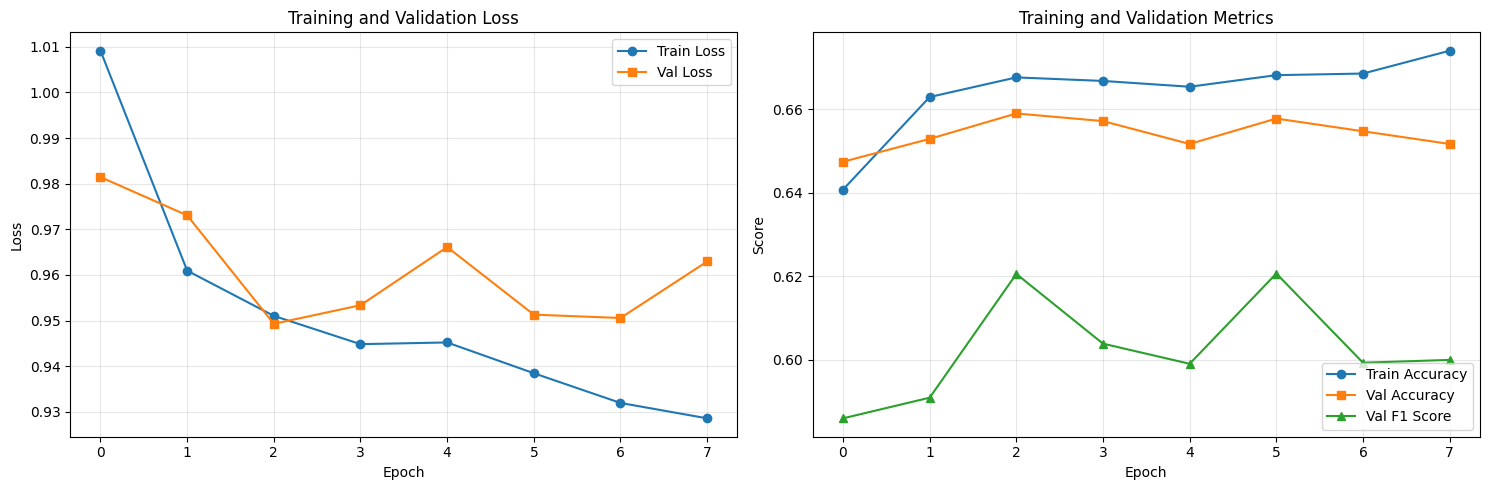


Best Training Accuracy: 0.6740
Best Validation Accuracy: 0.6590
Best Validation F1: 0.6206


In [58]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(training_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(training_history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(training_history['val_acc'], label='Val Accuracy', marker='s')
axes[1].plot(training_history['val_f1'], label='Val F1 Score', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
print(f"\nBest Training Accuracy: {max(training_history['train_acc']):.4f}")
print(f"Best Validation Accuracy: {max(training_history['val_acc']):.4f}")
print(f"Best Validation F1: {max(training_history['val_f1']):.4f}")

In [59]:
# Evaluate on test set
test_metrics = evaluate_classifier(
    model=classifier,
    test_loader=test_loader_classification,
    idx_to_label=idx_to_label
)

Evaluating: 100%|██████████| 52/52 [00:02<00:00, 23.54it/s]

TEST SET EVALUATION
Accuracy:          0.6556
F1 Score (weighted): 0.6000
F1 Score (macro):    0.3966
Precision:         0.6214
Recall:            0.6556

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

          CD       0.60      0.24      0.35       184
         HYP       0.00      0.00      0.00        56
          MI       0.57      0.24      0.34       256
        NORM       0.66      0.96      0.78       913
        STTC       0.68      0.42      0.52       243

    accuracy                           0.66      1652
   macro avg       0.50      0.37      0.40      1652
weighted avg       0.62      0.66      0.60      1652




/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

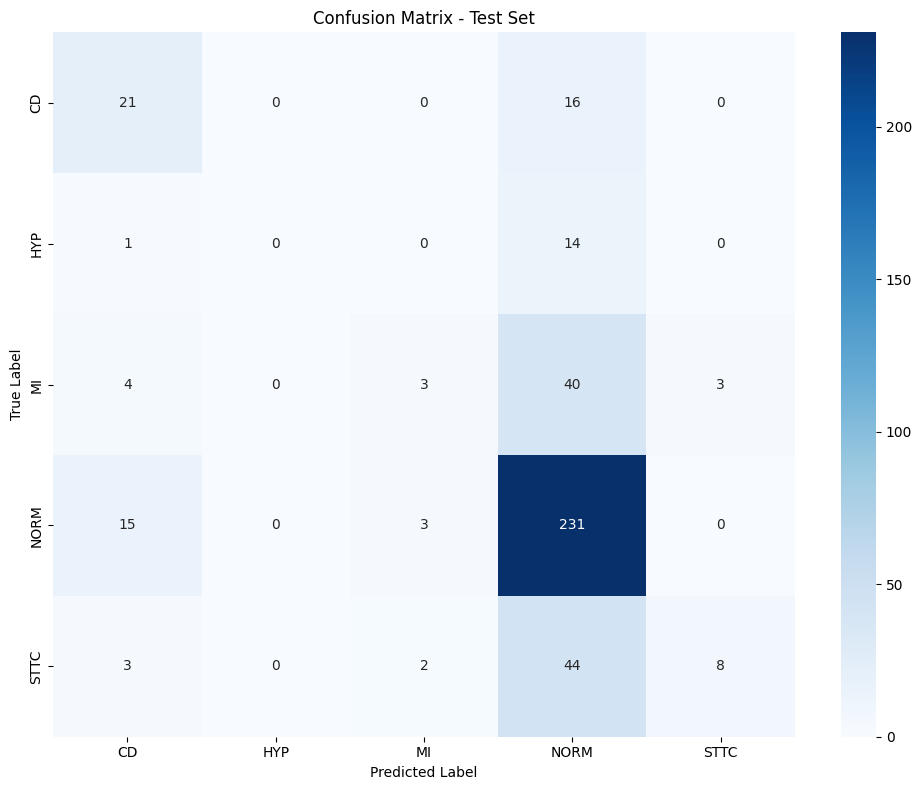


Per-Class Accuracy:
  CD                  : 0.5676 (21/37)
  HYP                 : 0.0000 (0/15)
  MI                  : 0.0600 (3/50)
  NORM                : 0.9277 (231/249)
  STTC                : 0.1404 (8/57)


In [62]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])
class_names = [idx_to_label[i] for i in range(len(idx_to_label))]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"  {class_name:20s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")

### Understanding the Results

The classifier evaluation provides insights into how well the pre-trained encoder's representations transfer to the downstream classification task:

**Key Metrics:**
- **Accuracy**: Overall percentage of correct predictions
- **F1 Score (Weighted)**: Harmonic mean of precision and recall, weighted by class support
- **F1 Score (Macro)**: Average F1 across all classes (treats all classes equally)
- **Precision**: Percentage of positive predictions that are correct
- **Recall**: Percentage of actual positives that are identified

**Interpreting Performance:**
- High test accuracy indicates good representation learning
- Compare with training from scratch to quantify the benefit of pre-training
- Per-class metrics reveal which diagnostic classes are easier/harder to classify
- Confusion matrix shows common misclassification patterns

**Architecture Notes:**
- The encoder is **frozen** (not updated during training)
- Only the classification head learns during training
- This tests the quality of the learned representations for downstream tasks

### Optional: Baseline Comparison

To validate that the pre-trained encoder learned useful representations, you can compare against a randomly initialized encoder:

In [ ]:
# Optional: Train classifier with random encoder (baseline)
# This helps quantify the benefit of pre-training

# Create a new random encoder with the same architecture
random_encoder = ECGEncoder(
    input_channels=12,
    d_model=512,
    nhead=8,
    num_layers=6,
    dim_feedforward=2048,
    dropout=0.1
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Train classifier on random features
print("Training classifier with RANDOM encoder (baseline)...")
baseline_classifier, baseline_history = train_classifier(
    encoder=random_encoder,
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=test_dataset_classification.num_classes,
    hidden_dim=256,
    num_epochs=30,
    learning_rate=1e-3,
    patience=5
)

# Evaluate baseline
print("\n" + "="*60)
print("BASELINE EVALUATION (Random Encoder)")
print("="*60)
baseline_metrics = evaluate_classifier(
    model=baseline_classifier,
    test_loader=test_loader_classification,
    idx_to_label=idx_to_label
)

# Compare results
print("\n" + "="*60)
print("COMPARISON: Pre-trained vs Random Encoder")
print("="*60)
print(f"Pre-trained Encoder Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Random Encoder Test Accuracy:      {baseline_metrics['accuracy']:.4f}")
print(f"Improvement:                        {(test_metrics['accuracy'] - baseline_metrics['accuracy']):.4f}")
print(f"Relative Improvement:               {((test_metrics['accuracy'] - baseline_metrics['accuracy']) / baseline_metrics['accuracy'] * 100):.2f}%")
print("="*60)

---

## Summary: Downstream Classification Workflow

This section evaluates the quality of the learned encoder representations using a simple downstream classification task. Here's the complete workflow:

### 1. **Data Preparation**
   - Created datasets with numerical labels using `ECGDataset(map_labels_to_int=True)`
   - Split into train/val/test sets with proper DataLoaders

### 2. **Model Architecture**
   - `SimpleClassifier`: Frozen encoder + trainable classification head
   - Only the classification head parameters are updated during training
   - This isolates the evaluation to the encoder's representation quality

### 3. **Training**
   - Uses `train_classifier()` function that accepts any encoder
   - Early stopping based on validation accuracy
   - Tracks loss, accuracy, and F1 score
   - Returns trained model and training history

### 4. **Evaluation**
   - Comprehensive metrics: accuracy, F1 (weighted & macro), precision, recall
   - Classification report per class
   - Confusion matrix visualization
   - Per-class accuracy breakdown

### 5. **Baseline Comparison (Optional)**
   - Compare against randomly initialized encoder
   - Quantifies the benefit of contrastive pre-training
   - Shows relative improvement from learned representations

### Usage Example:
```python
# Train classifier
classifier, history = train_classifier(
    encoder=your_pretrained_encoder,
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=num_classes
)

# Evaluate
metrics = evaluate_classifier(
    model=classifier,
    test_loader=test_loader_classification
)
```

This approach is a standard method for evaluating self-supervised learning models on downstream tasks.